End to end machine learning workflow to predict mortality within 180 days of last visit


This is step 2


The goal is this file is to combine patient demographics with date time information from their last visit

# Importing Packages and Data

In [28]:
# Package Import

import pandas as pd
from datetime import datetime

In [29]:
# import data

demographics = pd.read_csv('output/step_1_demographics.csv')
visit = pd.read_csv('input/visit_occurrence.csv')

# Create Train Demographics

In [30]:
# Preview demographics

demographics.head()

,person_id,year_of_birth,gender_source_value,ethnicity_source_value,death_datetime
0,19076,1937.0,2,1,NaN
1,63615,1971.0,2,1,NaN
2,138812,1935.0,2,1,NaN
3,24089,1943.0,1,1,NaN
4,21093,1933.0,2,1,NaN


In [31]:
# Preview visit

visit.head()

,provider_id,visit_start_date,preceding_visit_occurrence_id,admitting_source_value,person_id,discharge_to_source_value,care_site_id,visit_occurrence_id,visit_source_value,visit_end_date,visit_start_datetime,visit_concept_id,admitting_source_concept_id,visit_source_concept_id,visit_type_concept_id,discharge_to_concept_id,visit_end_datetime
0,NaN,2009-10-02,NaN,NaN,129617.0,NaN,4057.0,1863806,887153388320050,NaN,2009-10-02 05:15:48,0,44814675.0,NaN,44818517,44814705.0,NaN
1,NaN,2008-06-27,NaN,NaN,129971.0,NaN,20141.0,1981327,542052281252242,NaN,2008-06-27 06:22:51,9202,44814675.0,NaN,44818517,NaN,2008-06-27 12:20:32
2,NaN,2008-12-23,NaN,NaN,36583.0,NaN,19814.0,1911457,887643388534706,2008-12-23,2008-12-23 09:45:27,0,NaN,NaN,44818517,44814705.0,2008-12-23 16:53:50
3,NaN,2008-03-24,NaN,NaN,2217.0,NaN,9948.0,4798297,887063387982378,NaN,2008-03-24 16:49:19,0,44814683.0,NaN,44818517,44814705.0,NaN
4,NaN,2008-12-05,NaN,NaN,69007.0,NaN,33601.0,476064,887413385658720,NaN,2008-12-05 03:16:57,0,44814675.0,NaN,44818517,44814705.0,NaN


In [32]:
# Selecting person_id and visit_start_datetime as the features we need from visit
# reset index

visit = visit[['person_id','visit_start_datetime']]
visit = visit.reset_index(drop=True)

In [33]:
# Preview visit with selected features

visit.head()

,person_id,visit_start_datetime
0,129617.0,2009-10-02 05:15:48
1,129971.0,2008-06-27 06:22:51
2,36583.0,2008-12-23 09:45:27
3,2217.0,2008-03-24 16:49:19
4,69007.0,2008-12-05 03:16:57


In [34]:
# lets find the latest visit date for each person


# first we create a list of the unique person id's 
person_id_list = list(demographics['person_id'])



# For each person we will create a filtered data frame from visits to only include data from that patient
# Then we will select the latest date and store that into a list
latest_visit_date = []
for person in person_id_list:
    filtered_df = visit.loc[visit.person_id == person]
    filtered_df = filtered_df.reset_index(drop=True)
    latest_visit_date.append(filtered_df['visit_start_datetime'].max())
    


# we then add the latest visit date to the demographics table
demographics['latest_visit_date'] = latest_visit_date


In [35]:
# Preview the demographics table with new data added

demographics.head()

,person_id,year_of_birth,gender_source_value,ethnicity_source_value,death_datetime,latest_visit_date
0,19076,1937.0,2,1,NaN,2010-04-23 05:59:36
1,63615,1971.0,2,1,NaN,2009-09-06 01:18:59
2,138812,1935.0,2,1,NaN,2008-08-26 02:42:09
3,24089,1943.0,1,1,NaN,2010-03-16 06:23:08
4,21093,1933.0,2,1,NaN,2009-11-06 08:06:04


In [39]:
# we remove patients with NA value for latest_visit_date

demographics = demographics.loc[pd.notna(demographics['latest_visit_date'])]
demographics = demographics.reset_index(drop=True)


In [40]:
# Let's create the a new demographic feature, the age of the patient during their last visit
# we convert the string datetime to an actual date time object 
# we selct the year value and convert to an integer
# we subtract the birth year 

age_last_visit = []
for i in range(len(demographics)):
    age_last_visit.append(int(datetime.strptime(demographics.loc[i]['latest_visit_date'], '%Y-%m-%d %H:%M:%S').year) - demographics.loc[i]['year_of_birth'])
    
    
demographics['age_last_visit'] = age_last_visit


<AxesSubplot:>

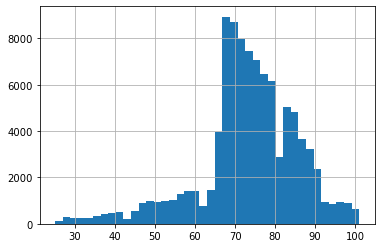

In [45]:
# lets visualize the age distribution from each last visit

demographics['age_last_visit'].hist(bins=40)

In [60]:
# lets create the outcome feature
# if there is no deathdate or the date difference of death date - latest visit > 180 days outcome = 0
# else outcome = 1
# 1 is died within 180 days of last visit
# 0 is did not die within 180 days of last visit

outcome = []
for i in range(len(demographics)):
    if(pd.isna(demographics.loc[i]['death_datetime'])==True):
        outcome.append(0)
    elif((datetime.strptime(demographics.loc[i]['death_datetime'], '%Y-%m-%d %H:%M:%S') - datetime.strptime(demographics.loc[i]['latest_visit_date'], '%Y-%m-%d %H:%M:%S')).days <= 180):                       
        outcome.append(1)
    else:
        outcome.append(0)

demographics['outcome'] = outcome    
    
    

In [62]:
# lets count how many of each class we have

print("Number of class 1: ",len(demographics.loc[demographics.outcome==1]))
print("Number of class 0: ",len(demographics.loc[demographics.outcome==0]))

Number of class 1:  520
Number of class 0:  97320


# IMPORTANT NOTE

Since we have SO MANY training examples, I am only going to select 10,000 to save time training and memory. However I will guarentee that all 520 from class 1 will be in the training set

In [68]:
# We use the pandas.sample with a fraction of 1 which just shuffles our dataframe
# we then sort the shuffled data frame by outcome and only select first 10000

train_demographics = demographics.sample(frac=1).sort_values(by='outcome',ascending=False).head(10000).reset_index(drop=True)


In [69]:
train_demographics.head()

,person_id,year_of_birth,gender_source_value,ethnicity_source_value,death_datetime,latest_visit_date,age_last_visit,outcome
0,138730,1981.0,1,1,2009-10-02 11:50:35,2009-07-07 13:12:14,28.0,1
1,127727,1944.0,1,2,2009-07-25 23:38:38,2009-02-21 13:11:27,65.0,1
2,46210,1941.0,1,3,2010-08-03 19:47:22,2010-05-20 12:20:52,69.0,1
3,10249,1929.0,2,2,2010-05-26 23:14:58,2009-12-01 16:23:09,80.0,1
4,78014,1931.0,1,1,2010-07-23 23:37:41,2010-05-05 05:51:12,79.0,1


In [70]:
print("Number outcome 1:",len(train_demographics.loc[train_demographics.outcome==1]))
print("Number outcome 0:",len(train_demographics.loc[train_demographics.outcome==0]))

Number outcome 1: 520
Number outcome 0: 9480


In [71]:
# preview train demographics

train_demographics.head()

,person_id,year_of_birth,gender_source_value,ethnicity_source_value,death_datetime,latest_visit_date,age_last_visit,outcome
0,138730,1981.0,1,1,2009-10-02 11:50:35,2009-07-07 13:12:14,28.0,1
1,127727,1944.0,1,2,2009-07-25 23:38:38,2009-02-21 13:11:27,65.0,1
2,46210,1941.0,1,3,2010-08-03 19:47:22,2010-05-20 12:20:52,69.0,1
3,10249,1929.0,2,2,2010-05-26 23:14:58,2009-12-01 16:23:09,80.0,1
4,78014,1931.0,1,1,2010-07-23 23:37:41,2010-05-05 05:51:12,79.0,1


# Export Data

In [74]:
train_demographics.to_csv('output/step_2_train_demographics',index=False)